# 0 TCLab Overview

The following cells in this notebook demonstrate the use of the Temperature Control Lab.

## TCLab Architecture
<img src='images/TCLabOverview.png' style="float: left;padding-right:30px;"></img>
**_Jupyter notebooks:_**
Examples, lessons, and student projects.

**_TCLab:_**
Provide high-level ccess to sensors, heaters, a pseudo-realtime clock.

**_sketch.ino:_**
Firmware for the intrisically safe operation of the Arduino board and shield.

**_Arduino:_**
Hardware platform for the Temperature Control Laboratory.

## Connecting to the Temperature Control Laboratory

### Importing

When used for the first time, the `tclab` package is installed with the command line

    pip install tclab
    
Once it has been installed, the package can be imported into Python and an instance created with the Python statements

    from tclab import TCLab
    a = TCLab()

TCLab() attempts to find a device connected to a serial port and returns a connection. An error is generated if no device is found.  The connection should be closed when no longer in use.

The following cell demonstrates this process, and uses the tclab `LED()` function to flash the LED on the Temperature Control Lab for a period of 10 seconds at a 100% brightness level. 

In [8]:
from tclab import TCLab

a = TCLab()
a.LED(100)
a.close()

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411
TCLab disconnected successfully.


### Using TCLab with Python's `with` statement

The Python `with` statement provides a convenient means of setting up and closing a connection to the Temperature Control Laboratory. In particular, the with statement establishes a context where a tclab instance is created, assigned to a variable, and automatically closed upon completion.

In [10]:
from tclab import TCLab

with TCLab() as a:
    a.LED(100)

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411
TCLab disconnected successfully.


The `with` statement is likely to be the most common way to connect the Temperature Control Laboratory for most uses.

## Reading Temperatures

Once a tclab instance is created and connected to a device, the temperature sensors on the temperature control lab can be acccessed with the attributes `.T1` and `.T2`.  For example, given an instance `a`, the temperatures are accessed as

    T1 = a.T1
    T2 = a.T2

Note that `a.T1` and `a.T2` are read-only properties. Any attempt to set them to a value will return a Python error.

In [4]:
from tclab import TCLab

with TCLab() as a:
    print("Temperature 1: {0:0.2f} C".format(a.T1))
    print("Temperature 2: {0:0.2f} C".format(a.T2))

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411
Temperature 1: 22.51 C
Temperature 2: 23.15 C
TCLab disconnected successfully.


## Setting Heaters

The heaters are controlled by functions`.Q1()` and `.Q2()` of a tclab instance. For example, both heaters can be set to 100% power with the functions

    a.Q1(100)
    a.Q2(100)

The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via

    Q1 = a.Q1()
    Q2 = a.Q2()
    
Note that the retrieved values may be different due to the range-limiting enforced by the device firmware.

In [5]:
from tclab import TCLab
import time

with TCLab() as a:
    print("\nStarting Temperature 1: {0:0.2f} C".format(a.T1),flush=True)
    print("Starting Temperature 2: {0:0.2f} C".format(a.T2),flush=True)

    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    t_heat = 30
    print("\nHeat for", t_heat, "seconds")
    time.sleep(t_heat)

    print("\nTurn Heaters Off")
    a.Q1(0)
    a.Q2(0)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    print("\nFinal Temperature 1: {0:0.2f} C".format(a.T1))
    print("Final Temperature 2: {0:0.2f} C".format(a.T2))

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411

Starting Temperature 1: 22.51 C
Starting Temperature 2: 23.48 C

Set Heater 1: 100.0 %
Set Heater 2: 100.0 %

Heat for 30 seconds

Turn Heaters Off

Set Heater 1: 0.0 %
Set Heater 2: 0.0 %

Final Temperature 1: 26.70 C
Final Temperature 2: 25.09 C
TCLab disconnected successfully.


## Syncronizing with real time using `clock`

For convenience, the tclab module includes a function `clock` for synchronizing calculations with real time.  `clock(tperiod, tstep)` is a python iterator that generates a sequence of iterations over a period of `tperiod` seconds separated by `tstep` seconds. 

In [6]:
from tclab import TCLab, clock

tperiod = 5
tstep = 1
for t in clock(tperiod,tstep):
    print(t, "sec.")

0.0 sec.
1.0 sec.
1.99 sec.
2.99 sec.
3.99 sec.
4.99 sec.


There are some considerations to keep in mind when using `clock`. Most important, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with the wall clock, but there is no guarantee.

Second, whatever calculations you perform inside the clock must take less than tstep seconds to complete, otherwise there is no way for `clock` to keep up with real time. Under normal usage, an error exception is raised if `clock` fails to keep up with real time.

There is an optional flag that allows clock to slip out of real time sync. The usage is

    clock(tfinal, tstep, strict=False)
    
which is demonstrated in the following cell where, for a certain interval, a calculation is performed that takes longer than tstep to complete.

In [7]:
from tclab import TCLab, clock

import time

tfinal = 12
tstep = 2
for t in clock(tfinal,tstep,strict=False):
    print(t, "sec.")
    if (t > 3) and (t < 5):
        time.sleep(2.2)

0.0 sec.
2.0 sec.
4.0 sec.
6.2 sec.
8.2 sec.
10.19 sec.


### Using `clock` with TCLab

In [8]:
from tclab import TCLab, clock

tperiod = 20

# connect to the temperature control lab
with TCLab() as a:
    # turn heaters on
    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1 to {0:f} %".format(a.Q1()))
    print("Set Heater 2 to {0:f} %".format(a.Q2()))

    # report temperatures for the next tperiod seconds
    sfmt = "   {0:5.1f} sec:   T1 = {1:0.1f} C    T2 = {2:0.1f} C"
    for t in clock(tperiod,1):
        print(sfmt.format(t, a.T1, a.T2), flush=True)
        

Connecting to TCLab
TCLab Firmware Version 1.2.1 connected on port /dev/cu.usbmodem1411

Set Heater 1 to 100.000000 %
Set Heater 2 to 100.000000 %
     0.0 sec:   T1 = 28.6 C    T2 = 26.1 C
     1.0 sec:   T1 = 28.6 C    T2 = 26.4 C
     2.0 sec:   T1 = 29.0 C    T2 = 27.0 C
     3.0 sec:   T1 = 29.0 C    T2 = 27.0 C
     4.0 sec:   T1 = 29.0 C    T2 = 27.0 C
     5.0 sec:   T1 = 29.0 C    T2 = 26.4 C
     6.0 sec:   T1 = 29.0 C    T2 = 26.4 C
     7.0 sec:   T1 = 29.3 C    T2 = 26.4 C
     8.0 sec:   T1 = 29.3 C    T2 = 27.3 C
     9.0 sec:   T1 = 29.3 C    T2 = 27.3 C
    10.0 sec:   T1 = 29.3 C    T2 = 26.7 C
    11.0 sec:   T1 = 29.6 C    T2 = 26.7 C
    12.0 sec:   T1 = 29.6 C    T2 = 26.7 C
    13.0 sec:   T1 = 29.6 C    T2 = 27.7 C
    14.0 sec:   T1 = 29.6 C    T2 = 27.7 C
    15.0 sec:   T1 = 29.9 C    T2 = 27.0 C
    16.0 sec:   T1 = 29.9 C    T2 = 27.0 C
    17.0 sec:   T1 = 29.9 C    T2 = 27.0 C
    18.0 sec:   T1 = 30.2 C    T2 = 28.0 C
    19.0 sec:   T1 = 30.2 C    T2 = 

## TCLab `Historian`

The `Historian` class provides means for real-time plotting and data logging. Given an instance of a TCLab object, an Historian is created with the command

    h = Historian(a)
    
The historian initializes a data log. The data log is updated by issuing a command

    h.update()
    
An optional real-time plot is initialized with the command

    h.initplot(tfinal)
    
where the optional parameter `tfinal` provides an initial scaling of the time axes. If a real-time plot has been initialized, then each call to `h.update()` also updates the plot.

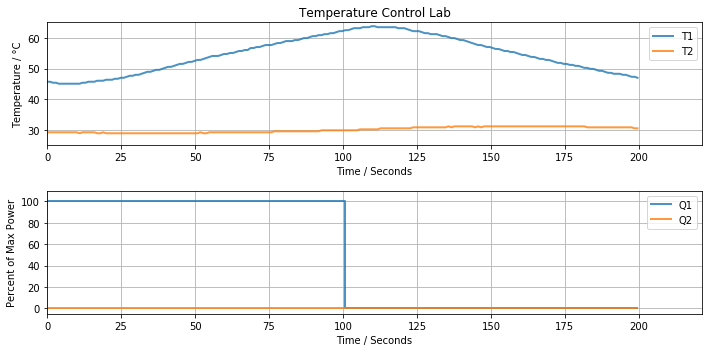

TCLab disconnected successfully.


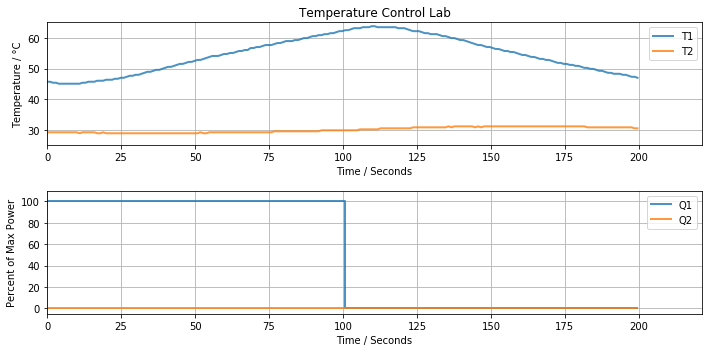

In [1]:
%matplotlib inline
from tclab import TCLab, clock, Historian

with TCLab() as a:
    h = Historian(a)
    h.initplot()
    for t in clock(200):
        a.Q1(100 if t < 100 else 0)
        h.update(t)

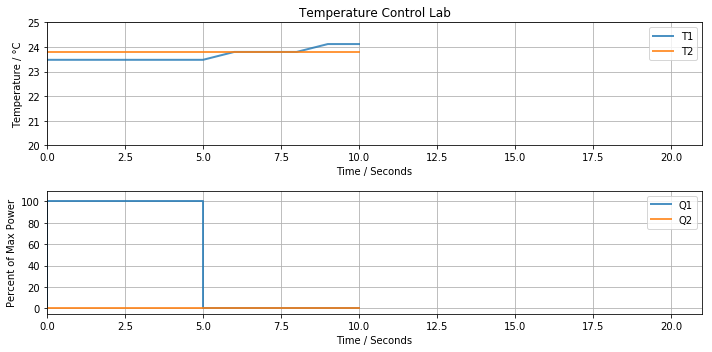

TCLab disconnected successfully.


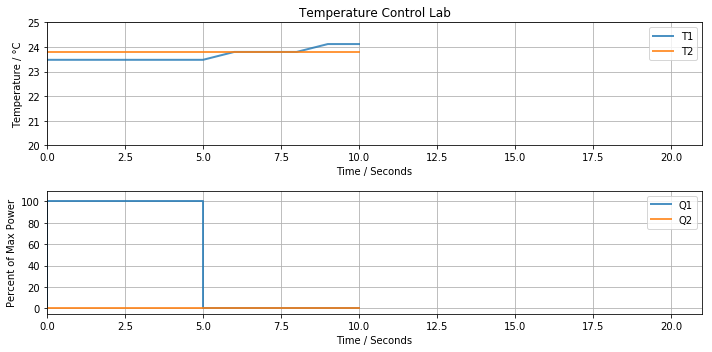

In [1]:
%matplotlib inline
from tclab import TCLab, clock, Historian

with TCLab() as a:
    h = Historian(a)
    h.initplot()
    for t in clock(10,strict=True):
        a.Q1(0 if t > 5 else 100)
        h.update(t)

In [5]:
h.log

[[0, 46.36, 29.28, 0.0, 0.0],
 [0.0, 46.36, 29.28, 100.0, 0.0],
 [1.0, 46.04, 29.6, 100.0, 0.0],
 [2.0, 46.04, 29.6, 100.0, 0.0],
 [3.0, 46.04, 29.6, 100.0, 0.0],
 [4.0, 45.71, 29.6, 100.0, 0.0],
 [5.0, 45.71, 29.6, 100.0, 0.0],
 [6.0, 45.71, 29.6, 100.0, 0.0],
 [7.0, 45.71, 29.6, 100.0, 0.0],
 [8.0, 45.71, 29.6, 100.0, 0.0],
 [9.0, 45.71, 29.6, 100.0, 0.0],
 [10.0, 45.71, 29.6, 100.0, 0.0],
 [11.0, 45.71, 29.6, 100.0, 0.0],
 [12.0, 45.71, 29.6, 100.0, 0.0],
 [13.0, 46.04, 29.6, 100.0, 0.0],
 [14.0, 46.04, 29.6, 100.0, 0.0],
 [15.0, 46.04, 29.6, 100.0, 0.0],
 [16.0, 46.36, 29.6, 100.0, 0.0],
 [17.0, 46.36, 29.6, 100.0, 0.0],
 [18.0, 46.68, 29.6, 100.0, 0.0],
 [19.0, 46.68, 29.6, 100.0, 0.0],
 [20.0, 47.0, 29.6, 100.0, 0.0],
 [21.0, 47.0, 29.6, 100.0, 0.0],
 [22.0, 47.32, 29.6, 100.0, 0.0],
 [23.0, 47.32, 29.6, 100.0, 0.0],
 [24.0, 47.65, 29.6, 100.0, 0.0],
 [25.0, 47.97, 29.6, 100.0, 0.0],
 [26.0, 47.97, 29.6, 100.0, 0.0],
 [27.0, 48.29, 29.6, 100.0, 0.0],
 [28.0, 48.29, 29.6, 100.0, 0